In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import math
import time
from keras import backend as K
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

Using TensorFlow backend.


In [2]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''
def plot_test(y_test,y_pred,start,end,string):
    #Plot of testing.
    plt.figure(figsize=(10,10))
    plt.plot(y_test[start:end],'r')
    plt.plot(y_pred[start+1:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.title(string)
    plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def nn_model(localdf,localdict,times,metric,num_cols,hour_day):
    for counter in range(times):
            #i = num_cols
        #for i in range(num_cols):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                print(localdf.columns[i])
                
                ndf = localdf
                x = ndf[ndf.columns[0:ndf.shape[1]]]
                print ("\n",x.columns)
                y = ndf[ndf.columns[-1:]]
                
                print (x.shape)
                print (y.shape)
                
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                train_size = int(70*x.shape[0]/100)
                X_train = x.values[:train_size]
                y_train = y.values[:train_size]
                    
                X_test = x.values[train_size:]
                y_test = y.values[train_size:]
                model = Sequential()
                model.add(Dense(10,input_dim=ndf.shape[1],kernel_initializer='normal', activation='relu'))
                #Output Layer.
                model.add(Dense(1,kernel_initializer='normal'))
                #Compile model.
                model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
                #Fit the model.
                history = model.fit(X_train,y_train,epochs=200,batch_size=200,verbose=1)
                #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = model.evaluate(X_test,y_test,verbose=1)
                y_pred = model.predict(X_test)
                y_pred[y_pred<0]=0
                print ("R2 Score : ",r2_score(y_test,y_pred))
                #print (str(coeff_determination(y_test,y_pred)))
                print ("Metric : %.5f" % (scores[1]))
                localdict.setdefault(counter,[]).append((scores[1]))
                model.summary()
                weights1 = model.layers[0].get_weights()[0]
                biases1 = model.layers[0].get_weights()[1]
                weights2 = model.layers[1].get_weights()[0]
                biases2 = model.layers[1].get_weights()[1]
                plot_test(y_test,y_pred,0,50,"ANN")
    return localdict,history,y_test,y_pred,scores,weights1, weights2, biases1, biases2 

In [3]:
data = pd.read_pickle('../Datasets/Pecan Street/New_Data/load_data_1632.pkl')
for i in data.columns:
    if data[i].isnull().sum() >= data.values.shape[0]-10000 : del data[i]

In [4]:
data = pd.DataFrame(data.values[175:],columns=data.columns)
data = data*1000

In [5]:
data['air1'][34492] = (data['air1'][34492-168] + data['air1'][34492+168])/2
data['air2'][34492] = (data['air2'][34492-168] + data['air2'][34492+168])/2
data['grid'][34492] = (data['grid'][34492-168] + data['grid'][34492+168])/2
data['outsidelights_plugs1'][34492] = (data['outsidelights_plugs1'][34492-168] + data['outsidelights_plugs1'][34492+168])/2
data['outsidelights_plugs2'][34492] = (data['outsidelights_plugs2'][34492-168] + data['outsidelights_plugs2'][34492+168])/2
data['refrigerator1'][34492] = 0.0
x = data.values[34492][2:]
data['use'][34492] = sum(x[1:])

In [6]:
data.isnull().sum()

dataid                     0
localhour                  0
use                        0
air1                       0
air2                       0
air3                       0
bathroom1                  0
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                      0
furnace1                   0
furnace2                   0
garage1                    0
garage2                    0
grid                       0
kitchenapp1                0
kitchenapp2                0
lights_plugs1              0
lights_plugs2              0
microwave1                 0
outsidelights_plugs1       0
outsidelights_plugs2       0
refrigerator1           7767
waterheater1               0
dtype: int64

In [7]:
df_thermal = data[['air1','air2','air3','furnace1','furnace2','waterheater1']].copy()
df_thermal['tot'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']
df_tot_ther = df_thermal[['tot']]

In [8]:
nhrs = int(df_tot_ther.values.shape[0]/24)
y = np.ndarray(shape=(nhrs,))
val = []
for i in range(nhrs):
    val = df_tot_ther.values[i:i+24]
    y[i] = sum(val)
y = y[7:]
x = df_tot_ther.values

In [ ]:
#leave empty to add proper nn model call fn

In [ ]:
'''weather = pd.read_csv("E:\\TherML\\Datasets\\Pecan Street\\Weather data\\weather_data.csv",dtype='object')
d = open("E:\\TherML\\Datasets\\Pecan Street\\Weather data\\labels_weather.txt",'r').read()
d = d.split('|')[3:]
d = [k.strip() for k in d]
t = [d[k] for k in range(len(d)) if k%2==1]
t.append(d[0])
t = t[-1:] + t[:-1]
t = [x for x in t if x != '']
weather.columns = t
weather.isnull().sum()
weather.to_csv("E:\\TherML\\Datasets\\Pecan Street\\Weather data\\weather_data1.csv", encoding='utf8', index=False)'''

In [9]:
weather = pd.read_csv("..\\Datasets\\Pecan Street\\Weather data\\weather_data1.csv",dtype='object')
for i in weather.columns:
    if weather[i].isnull().sum() >= weather.values.shape[0]-60000 : del weather[i]
'''
t1 = weather['latitude'].str.contains('30.')
t2 = [c for c in range(len(t1)) if t1[c] == True]
t2[-1]
'''
weather = pd.DataFrame(weather.values[19495:58821], columns=weather.columns)
weather.isnull().sum()

timestamp                  0
latitude                   0
longitude                  0
tz_offset                  0
Label                      0
temperature                0
dew_point                  0
humidity                   0
visibility                 0
apparent_temperature       0
pressure                   0
wind_speed                46
cloud_cover             2234
wind_bearing             201
precip_intensity           0
precip_probability         0
dtype: int64

In [10]:
weather_new = pd.DataFrame(weather.iloc[:,1:], columns=weather.columns[1:])
for i in weather_new.columns:
    if(i!='timestamp'):
        print(i)
        weather_new[i] = pd.to_numeric(weather_new[i])
        if(weather_new[i].isnull().sum()!=0):
            for j in range(weather_new.values.shape[0]):
                if(np.isnan(weather_new[i][j])):
                    weather_new[i][j] = 0.0
weather_new.isnull().sum()

latitude
longitude
tz_offset
Label
temperature
dew_point
humidity
visibility
apparent_temperature
pressure
wind_speed


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


cloud_cover
wind_bearing
precip_intensity
precip_probability


latitude                0
longitude               0
tz_offset               0
Label                   0
temperature             0
dew_point               0
humidity                0
visibility              0
apparent_temperature    0
pressure                0
wind_speed              0
cloud_cover             0
wind_bearing            0
precip_intensity        0
precip_probability      0
dtype: int64

In [11]:
df_tot_ther = pd.DataFrame(df_tot_ther.values[:39326], columns=df_tot_ther.columns)
weather['total_load'] = df_tot_ther[['tot']]

In [12]:
thermal_dict1 = {}
model_history1 = {}

precip_probability

 Index(['latitude', 'longitude', 'tz_offset', 'Label', 'temperature',
       'dew_point', 'humidity', 'visibility', 'apparent_temperature',
       'pressure', 'wind_speed', 'cloud_cover', 'wind_bearing',
       'precip_intensity', 'precip_probability'],
      dtype='object')
(39326, 15)
(39326, 1)
Epoch 1/200
27528/27528 [==============================] - 9s 342us/step - loss: 13.9772 - mean_squared_error: 13.9772
Epoch 2/200
27528/27528 [==============================] - 1s 35us/step - loss: 0.1233 - mean_squared_error: 0.1233
Epoch 3/200
27528/27528 [==============================] - 1s 29us/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 4/200
27528/27528 [==============================] - 1s 28us/step - loss: 0.0232 - mean_squared_error: 0.0232
Epoch 5/200
27528/27528 [==============================] - 1s 28us/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 6/200
27528/27528 [==============================] - 1s 32us/step - loss: 0.0206 - mean_squa

27528/27528 [==============================] - 1s 27us/step - loss: 3.0716e-04 - mean_squared_error: 3.0716e-04
Epoch 67/200
27528/27528 [==============================] - 1s 29us/step - loss: 5.1898e-04 - mean_squared_error: 5.1898e-04
Epoch 68/200
27528/27528 [==============================] - 1s 28us/step - loss: 4.4873e-04 - mean_squared_error: 4.4873e-04
Epoch 69/200
27528/27528 [==============================] - 1s 26us/step - loss: 8.2331e-04 - mean_squared_error: 8.2331e-04
Epoch 70/200
27528/27528 [==============================] - 1s 28us/step - loss: 4.2168e-04 - mean_squared_error: 4.2168e-04
Epoch 71/200
27528/27528 [==============================] - 1s 31us/step - loss: 6.4770e-04 - mean_squared_error: 6.4770e-04
Epoch 72/200
27528/27528 [==============================] - 1s 31us/step - loss: 3.8825e-04 - mean_squared_error: 3.8825e-04
Epoch 73/200
27528/27528 [==============================] - 1s 28us/step - loss: 4.6519e-04 - mean_squared_error: 4.6519e-04
Epoch 74/200


27528/27528 [==============================] - 1s 27us/step - loss: 2.7925e-04 - mean_squared_error: 2.7925e-04
Epoch 132/200
27528/27528 [==============================] - 1s 27us/step - loss: 3.6531e-04 - mean_squared_error: 3.6531e-04
Epoch 133/200
27528/27528 [==============================] - 1s 27us/step - loss: 4.6781e-04 - mean_squared_error: 4.6781e-04
Epoch 134/200
27528/27528 [==============================] - 1s 29us/step - loss: 3.3898e-04 - mean_squared_error: 3.3898e-04
Epoch 135/200
27528/27528 [==============================] - 1s 28us/step - loss: 2.1502e-04 - mean_squared_error: 2.1502e-04
Epoch 136/200
27528/27528 [==============================] - 1s 29us/step - loss: 4.8792e-04 - mean_squared_error: 4.8792e-04
Epoch 137/200
27528/27528 [==============================] - 1s 28us/step - loss: 1.8818e-04 - mean_squared_error: 1.8818e-04
Epoch 138/200
27528/27528 [==============================] - 1s 29us/step - loss: 3.5418e-04 - mean_squared_error: 3.5418e-04
Epoch 

27528/27528 [==============================] - 1s 32us/step - loss: 2.0763e-04 - mean_squared_error: 2.0763e-04
Epoch 197/200
27528/27528 [==============================] - 1s 33us/step - loss: 2.3781e-04 - mean_squared_error: 2.3781e-04
Epoch 198/200
27528/27528 [==============================] - 1s 35us/step - loss: 2.5087e-04 - mean_squared_error: 2.5087e-04
Epoch 199/200
27528/27528 [==============================] - 1s 31us/step - loss: 2.0415e-04 - mean_squared_error: 2.0415e-04
Epoch 200/200
11798/11798 [==============================] - 1s 68us/step
R2 Score :  0.99758032655
Metric : 0.00006
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 171
Trainable params: 171
Non-trainable params: 0

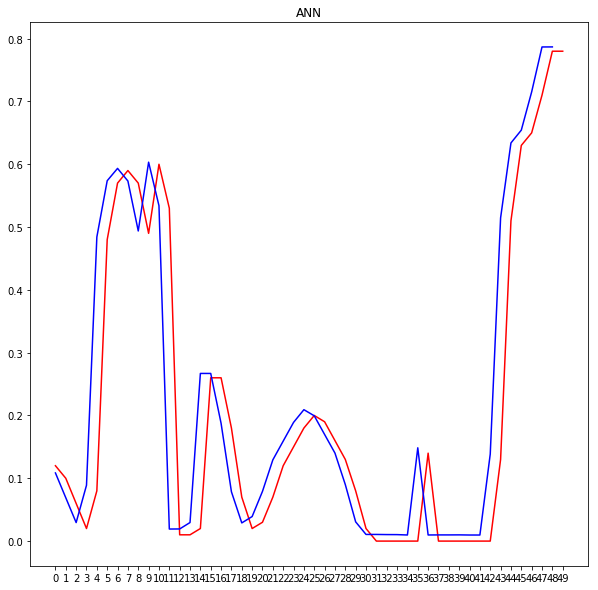

weights [[ -6.18110318e-03  -5.10723256e-02  -1.62745621e-02  -8.49932339e-03
    3.96944918e-02   7.35649914e-02   6.45142719e-02   6.72242697e-03
    1.40501723e-01   1.66662056e-02]
 [ -3.59440688e-03  -2.07341257e-02   3.84152159e-02   5.55679910e-02
    1.56732313e-02   1.10954396e-01  -3.71678136e-02   4.80928645e-02
    2.52308343e-02   8.63126740e-02]
 [  6.03844645e-03  -1.15697342e-03  -5.21070976e-03   5.98883703e-02
    7.98807815e-02   8.16276995e-04   1.42528266e-02   6.20474666e-02
   -2.82439478e-02  -1.47935254e-02]
 [  2.62367260e-02   1.66334230e-02  -4.03554961e-02   2.72035804e-02
    1.41340704e-03   1.99025627e-02   2.37388313e-02  -1.86600871e-02
    5.86350523e-02   7.99256861e-02]
 [  1.09675387e-02   3.67396651e-03   2.48002429e-02   8.90083313e-02
    7.29457140e-02   2.56184582e-02  -1.05086409e-01  -1.43320998e-02
    3.61693576e-02  -1.67448225e-03]
 [ -1.72516834e-02   2.20660754e-02   1.07177822e-02  -8.33831131e-02
   -2.32434310e-02  -2.34360769e-02  

In [13]:
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(weather_new,thermal_dict1,1,"mean_squared_error",weather_new.shape[1]-1,0)
tf = time.time()
print("weights",w1,"biases",b1,"weights",w2,"biases",b2)
print ("Time Taken : ",tf-ti)
print (thermal_dict1)